In [3]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
from collections import deque

%matplotlib inline

In [4]:
def load_data():
    # Loading + training,validation test split
    cars0 = glob.glob('Car_dataset/vehicles/GTI_Far/*.png')
    cars1 = glob.glob('Car_dataset/vehicles/GTI_MiddleClose/*.png')
    cars2 = glob.glob('Car_dataset/vehicles/GTI_Left/*.png')
    cars3 = glob.glob('Car_dataset/vehicles/GTI_Right/*.png')
    cars4 = glob.glob('Car_dataset/vehicles/KITTI_extracted/*.png')
    #cars4 += glob.glob('./vehicles/augmentation/*.png')
    notcars1 = glob.glob('Car_dataset/non-vehicles/Extras/*.png')
    notcars1 += glob.glob('Car_dataset/non-vehicles/GTI/*.png')

    # split 70% training 20% validation 10% test set
    frac1 = 0.7
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L1 = (frac1*np.array([l0,l1,l2,l3,l4,l5])).astype('int')
    frac2 = 0.9
    l0,l1,l2,l3,l4,l5=len(cars0),len(cars1),len(cars2),len(cars3),len(cars4),len(notcars1)
    L2 = (frac2*np.array([l0,l1,l2,l3,l4,l5])).astype('int')

    cars_train = cars0[:L1[0]] + cars1[:L1[1]] + cars2[:L1[2]] + cars3[:L1[3]] + cars4[:L1[4]]
    notcars_train = notcars1[:L1[5]]

    cars_val = cars0[L1[0]:L2[0]] + cars1[L1[1]:L2[1]] + cars2[L1[2]:L2[2]] + cars3[L1[3]:L2[3]] + cars4[L1[4]:L2[4]]
    notcars_val = notcars1[L1[5]:L2[5]]

    cars_test = cars0[L2[0]:] + cars1[L2[1]:] + cars2[L2[2]:] + cars3[L2[3]:] + cars4[L2[4]:]
    notcars_test = notcars1[L2[5]:]
    
    print(L1, L2)
    
    return cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test

[ 583  293  636  464 4176 6277] [ 750  377  818  597 5369 8071]
Number of samples in cars training set:  6152
Number of samples in notcars training set:  6277
Number of samples in cars validation set:  1759
Number of samples in notcars validation set:  1794
Number of samples in cars test set:  881
Number of samples in notcars test set:  897
car_image.shape (64, 64, 3)


Text(0.5,1,'Example Random Not-car Image')

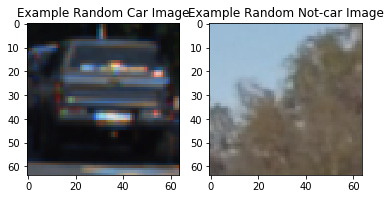

In [5]:
# images are divided up into vehicles and non-vehicles

car_images = glob.glob('Car_dataset/vehicles/**/*.png', recursive=True)
non_car_images = glob.glob('Car_dataset/non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in car_images:
     cars.append(image)

for image in non_car_images:
     notcars.append(image)

cars_train, notcars_train, cars_val, notcars_val, cars_test, notcars_test = load_data()
    
print('Number of samples in cars training set: ', len(cars_train))
print('Number of samples in notcars training set: ', len(notcars_train))

print('Number of samples in cars validation set: ', len(cars_val))
print('Number of samples in notcars validation set: ', len(notcars_val))

print('Number of samples in cars test set: ',len(cars_test))
print('Number of samples in notcars test set: ',len(notcars_test))
  
randomcar_index = np.random.randint(0, len(cars_train))
randomnotcar_index = np.random.randint(0, len(notcars_train))
    
# Read in car / not-car images
randomcar_image = mpimg.imread(cars_train[randomcar_index])
print('car_image.shape', randomcar_image.shape)
notcar_image = mpimg.imread(notcars_train[randomnotcar_index])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(randomcar_image)
plt.title('Example Random Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Random Not-car Image')

In [2]:
#Create HOG to improve feature classification. pixels_per_cell=(8, 8), cells_per_block=(2, 2), and orientations=9

from skimage.feature import hog
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec)
        return features

image indices 2431


Text(0.5,1,'HOG Car')

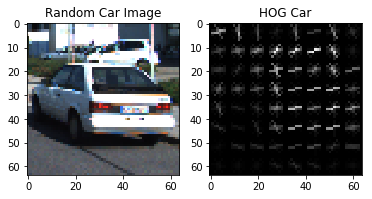

In [5]:
#visualize HOG applied to a random car in training set

#random index generation to apply HOG on
index = np.random.randint(0,len(cars_train))
print("image indices", index)

#read and print original images first
img = mpimg.imread(cars_train[index])
grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Random Car Image')

#Define HOG parameters
orient=9
pix_per_cell=8
cell_per_block=2

#Apply HOG
features1, hog_carimage = get_hog_features(grayimg, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)                         

#Print HOG of the random car sample
plt.subplot(122)
plt.imshow(hog_carimage, cmap='gray')
plt.title('HOG Car')

In [6]:
# Read in an image

# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

Text(0.5,1,'Random Car Image')

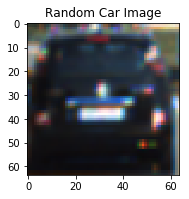

In [7]:
# Generate a random index to look at a car image later to be converted

index = np.random.randint(0,len(cars_train))
img = mpimg.imread(cars_train[index])
fig = plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.title('Random Car Image')


Text(0.5,1,'Spatially Binned Features')

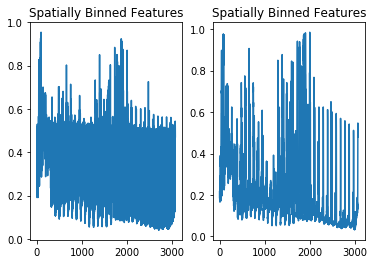

In [8]:
feature_vec1 = bin_spatial(img, color_space='YCrCb', size=(32, 32))

# Plot features using YCrCb
plt.subplot(121)
plt.plot(feature_vec1)
plt.title('Spatially Binned Features')

feature_vec2 = bin_spatial(img, color_space='RGB', size=(32, 32))

# Plot features using RGB
plt.subplot(122)
plt.plot(feature_vec2)
plt.title('Spatially Binned Features')

#conclusion: RGB looks more accurate

In [9]:
#Function to compute color histogram features
def colorhisto(img, nbins=32, bins_range=(0,256)):
    #Compute RGB histogram channels
    ChannelR_histo = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ChannelG_histo = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ChannelB_histo = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    #Concatenate data from each channel histo to a feature vector
    histo_features = np.concatenate((ChannelR_histo[0],ChannelG_histo[0],ChannelB_histo[0]))
    
    #Return the feature vector
    return histo_features

In [10]:
#Function that applies all these feature maps to an image

def feature_map_toimage(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                        orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    #Define a list to store features
    
    image_features=[]
    
    #Convert if not in RGB
    # Convert image to new color space
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
        
    #Check for spatial features flag and add to features if set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=(32, 32))
        image_features.append(spatial_features)
    
    #Check for colorhistogram features flag and add to features if set
    if hist_feat == True:
        colorhisto_features = colorhisto(feature_image, nbins=hist_bins)
        image_features.append(colorhisto_features)

        
    #Check for HOG features flag and add to features if set
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
         if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features) 
         else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
    #Append features to feature list
    image_features.append(hog_features)

   #Return concatenated array of features
    return np.concatenate(image_features)

In [11]:
#Function to extract features from each file by going over a loop for all images in the file

def get_features_fromfile(files, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features_file = []
    for file in files:
        
        img = mpimg.imread(file)
        img_features = feature_map_toimage(img, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        features_file.append(img_features)
    return features_file

In [12]:
#Define parameters to call the file feat extract function on training,validation and test set

color_space='RGB'
spatial_size = (16,16)
hist_bins = 32
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

#track time required to extract features

t_start=time.time()

#start feature extraction for training, validation and test set

cars_train_feats = get_features_fromfile(cars_train, color_space, spatial_size, hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)

cars_val_feats = get_features_fromfile(cars_val, color_space, spatial_size, hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)

cars_test_feats = get_features_fromfile(cars_test, color_space, spatial_size, hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)

notcars_train_feats = get_features_fromfile(notcars_train, color_space, spatial_size, hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)

notcars_val_feats = get_features_fromfile(notcars_val, color_space, spatial_size, hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)

notcars_test_feats = get_features_fromfile(notcars_test, color_space, spatial_size, hist_bins, orient, 
                                            pix_per_cell, cell_per_block, hog_channel,
                                            spatial_feat, hist_feat, hog_feat)

t_end=time.time()
print("Total time taken to train datasets with HOG, spatial and color histogram:", round(t_end-t_start),"seconds")

Total time taken to train datasets with HOG, spatial and color histogram: 57 seconds


In [13]:
#Create an array stack of feature vectors
    
X = np.vstack((cars_train_feats,cars_val_feats,cars_test_feats,
              notcars_train_feats,notcars_val_feats,notcars_test_feats)).astype(np.float64)

#Print length of feature vector X

print("Total number of feature parameters for an image:",len(X[1]))

#Apply standard scaling to inputs

X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

Total number of feature parameters for an image: 10224


In [25]:
#Calculate length of each - training, validation and test feature vectors

cars_train_feat_len = len(cars_train_feats)
cars_val_feat_len = len(cars_val_feats)
cars_test_feat_len = len(cars_test_feats)
notcars_train_feat_len = len(notcars_train_feats)
notcars_val_feat_len = len(notcars_val_feats)
notcars_test_feat_len = len(notcars_test_feats)

#Create indices

i1 = cars_train_feat_len
i2 = i1 + cars_val_feat_len
i3 = i2 + cars_test_feat_len
i4 = i3 + notcars_train_feat_len
i5 = i4 + notcars_val_feat_len

#Stack training, validation and test feature vectors seperately

X_train = np.vstack((X_scaled[:i1],X_scaled[i3:i4]))
X_val = np.vstack((X_scaled[i1:i2],X_scaled[i4:i5]))
X_test = np.vstack((X_scaled[i2:i3],X_scaled[i5:]))

y_train = np.hstack((np.zeros(notcars_train_feat_len),np.ones(cars_train_feat_len)))
y_val = np.hstack((np.zeros(notcars_val_feat_len),np.ones(cars_val_feat_len)))
y_test = np.hstack((np.zeros(notcars_test_feat_len),np.ones(cars_test_feat_len)))

X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_val,y_val = shuffle(X_val,y_val,random_state=42)
X_test,y_test = shuffle(X_test,y_test,random_state=42)

#Cross-verify dimensions

print (len(X_train[1]),len(X_val[1]),len(X_test[1]))
print (len(X_train),len(X_val),len(X_test))
print(X_train.shape)


10224 10224 10224
12429 3553 1778
(12429, 10224)


In [27]:

#Model setup
from keras import regularizers
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(32,32,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer= regularizers.l2(0.01)))
# model.add(Dense(120, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(84, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

ValueError: could not convert string to float: 'Car_dataset/vehicles/GTI_Far/image0110.png'